In [1]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

## Define Dataset

In [2]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [3]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [4]:
from vunet_model import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

## Build Learner

In [5]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard, valid_leaderboard2], model_dir=folder_to_save_models, cbs=CSVLogger)

In [6]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [10]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

## Training

In [11]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,82.518250,6.059697,0.002984,0.002984,37:04
1,29.296463,0.066423,0.002888,0.002888,36:28


In [12]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

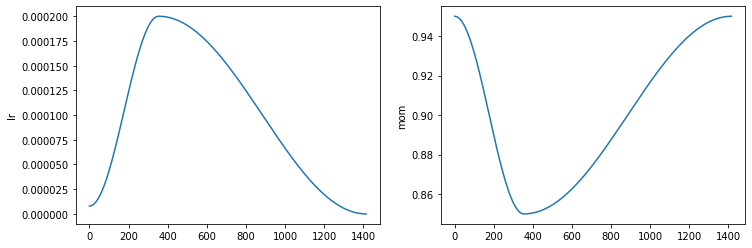

In [13]:
learn.recorder.plot_sched()

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.322788,0.317486,0.004964,0.004964,36:16
1,0.223381,0.004076,0.002363,0.002363,36:13


In [15]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [16]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.125142,0.052664,0.003794,0.003794,40:49
1,0.037557,0.002450,0.002057,0.002057,39:27


In [17]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [18]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.064689,0.022935,0.001123,0.001123,40:20
1,0.022693,0.002279,0.001968,0.001968,43:00


In [19]:
learn.save('Comb_8')

Path('weights/Comb_8.pth')

## Testing

In [7]:
learn.load('Comb_8')

In [8]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [9]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
sample = preds[0][0].cpu().detach().numpy()
print(sample.shape)

(32, 256, 256)


In [10]:
label = y[0].cpu().detach().numpy()
print(label.shape)

(32, 256, 256)


In [11]:
sample = recover(sample, 17, 32)
label = recover(label, 17, 32)

In [12]:
print(sample[:,0,0])
print(label[:,0,0])

[22.197102 22.096024 21.827911 22.91219  22.16757  22.121206 22.242018
 22.172413 21.879272 21.716543 22.58049  22.130047 22.513214 21.995981
 20.912529 22.14615  21.299675 22.11035  21.107153 21.021334 22.30839
 21.66824  22.423187 22.299252 21.651806 21.677746 21.941662 21.318913
 21.518394 21.51659  21.430262 21.389702]
[22.51   22.6175 22.69   22.6375 22.7575 22.7    22.9175 22.6075 22.8475
 22.66   22.87   22.645  22.76   22.915  22.535  22.645  22.49   22.95
 22.6525 22.7275 22.625  22.5325 22.6    22.6525 22.62   22.4825 22.6025
 22.7225 22.995  22.8675 23.02   23.0725]


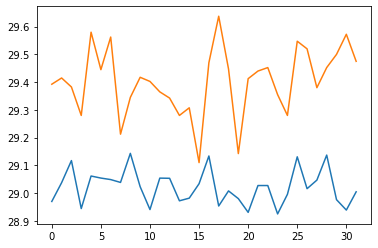

In [13]:
plt.plot(sample[:,200,6])
plt.plot(label[:,200,6])

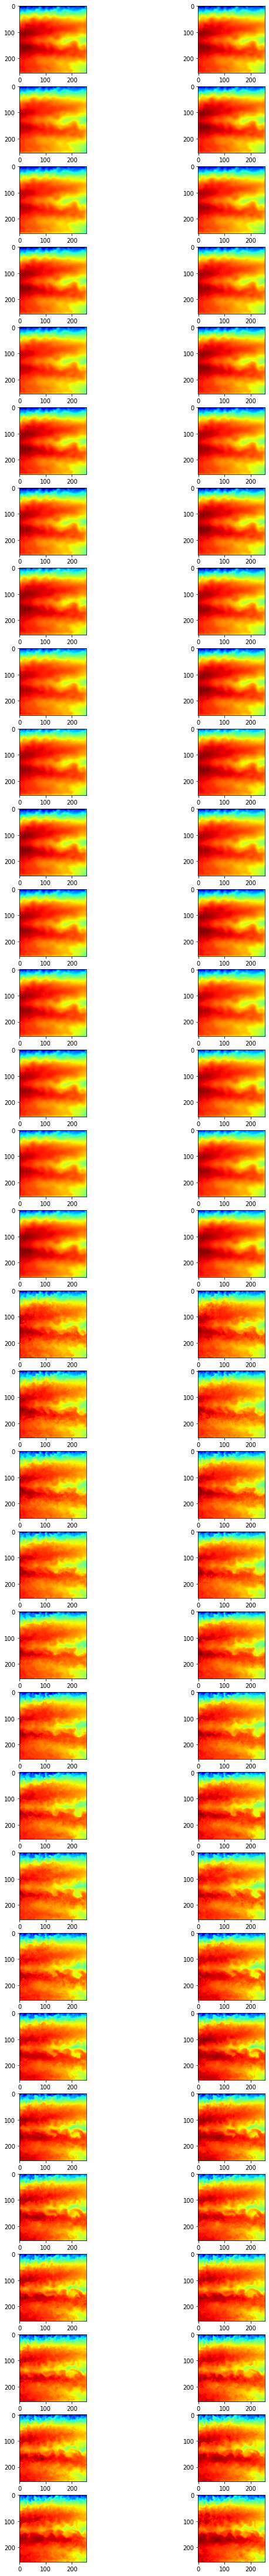

In [14]:
plt.figure(figsize=(10,80))
for i in range(sample.shape[0]):
    plt.subplot(sample.shape[0], 2, i+1)
    plt.imshow(sample[i], cmap='jet')
    plt.subplot(sample.shape[0], 2, i+1+sample.shape[0])
    plt.imshow(label[i], cmap='jet')
